# Use VPG to Play CartPole-v0

PyTorch version

In [1]:
%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions

logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('CartPole-v0')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

22:53:56 [INFO] env: <CartPoleEnv<CartPole-v0>>
22:53:56 [INFO] action_space: Discrete(2)
22:53:56 [INFO] observation_space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
22:53:56 [INFO] reward_range: (-inf, inf)
22:53:56 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}
22:53:56 [INFO] _max_episode_steps: 200
22:53:56 [INFO] _elapsed_steps: None
22:53:56 [INFO] id: CartPole-v0
22:53:56 [INFO] entry_point: gym.envs.classic_control:CartPoleEnv
22:53:56 [INFO] reward_threshold: 195.0
22:53:56 [INFO] nondeterministic: False
22:53:56 [INFO] max_episode_steps: 200
22:53:56 [INFO] _kwargs: {}
22:53:56 [INFO] _env_name: CartPole


In [3]:
class VPGAgent:
    def __init__(self, env,):
        self.action_n = env.action_space.n
        self.gamma = 0.99

        self.policy_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[],
                output_size=self.action_n, output_activator=nn.Softmax(1))
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.005)

    def build_net(self, input_size, hidden_sizes, output_size,
            output_activator=None, use_bias=False):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size, bias=use_bias))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        model = nn.Sequential(*layers)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, done):
        state_tensor = torch.as_tensor(observation, dtype=torch.float).unsqueeze(0)
        prob_tensor = self.policy_net(state_tensor)
        action_tensor = distributions.Categorical(prob_tensor).sample()
        action = action_tensor.numpy()[0]
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
        return action

    def close(self):
        if self.mode == 'train':
            self.learn()

    def learn(self):
        state_tensor = torch.as_tensor(self.trajectory[0::4], dtype=torch.float)
        reward_tensor = torch.as_tensor(self.trajectory[1::4], dtype=torch.float)
        action_tensor = torch.as_tensor(self.trajectory[3::4], dtype=torch.long)
        arange_tensor = torch.arange(state_tensor.shape[0], dtype=torch.float)
        discount_tensor = self.gamma ** arange_tensor
        discounted_reward_tensor = discount_tensor * reward_tensor
        discounted_return_tensor = discounted_reward_tensor.flip(0).cumsum(0).flip(0)
        all_pi_tensor = self.policy_net(state_tensor)
        pi_tensor = torch.gather(all_pi_tensor, 1,
                action_tensor.unsqueeze(1)).squeeze(1)
        log_pi_tensor = torch.log(torch.clamp(pi_tensor, 1e-6, 1.))
        loss_tensor = -(discounted_return_tensor * log_pi_tensor).mean()
        self.optimizer.zero_grad()
        loss_tensor.backward()
        self.optimizer.step()


agent = VPGAgent(env)

22:53:56 [INFO] ==== train ====
22:53:56 [DEBUG] train episode 0: reward = 72.00, steps = 72
22:53:56 [DEBUG] train episode 1: reward = 50.00, steps = 50
22:53:56 [DEBUG] train episode 2: reward = 40.00, steps = 40
22:53:56 [DEBUG] train episode 3: reward = 46.00, steps = 46
22:53:56 [DEBUG] train episode 4: reward = 24.00, steps = 24
22:53:56 [DEBUG] train episode 5: reward = 128.00, steps = 128
22:53:56 [DEBUG] train episode 6: reward = 74.00, steps = 74
22:53:56 [DEBUG] train episode 7: reward = 53.00, steps = 53
22:53:56 [DEBUG] train episode 8: reward = 29.00, steps = 29
22:53:56 [DEBUG] train episode 9: reward = 44.00, steps = 44
22:53:56 [DEBUG] train episode 10: reward = 75.00, steps = 75
22:53:56 [DEBUG] train episode 11: reward = 34.00, steps = 34
22:53:56 [DEBUG] train episode 12: reward = 69.00, steps = 69
22:53:56 [DEBUG] train episode 13: reward = 18.00, steps = 18
22:53:56 [DEBUG] train episode 14: reward = 19.00, steps = 19
22:53:56 [DEBUG] train episode 15: reward = 11

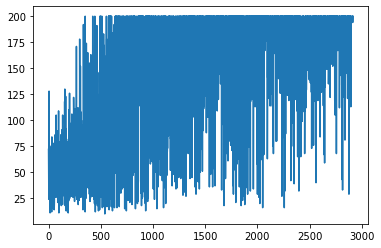

In [4]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-20:]) > 199:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [5]:
env.close()